<a href="https://colab.research.google.com/github/ishalyminov/Practical_RL/blob/coursera/week5_policy_based/practice_reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REINFORCE in TensorFlow

Just like we did before for q-learning, this time we'll design a neural network to learn `CartPole-v0` via policy gradient (REINFORCE).

In [1]:
! wget https://github.com/ishalyminov/Practical_RL/raw/coursera/setup_google_colab.py -O setup_google_colab.py
! pip install gym==0.14.0
! apt-get update
! apt-get install -y xvfb
! wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb
! apt-get install -y python-opengl ffmpeg
! pip install pyglet==1.2.4

from setup_google_colab import setup_week5
setup_week5()

--2020-04-04 22:00:19--  https://github.com/ishalyminov/Practical_RL/raw/coursera/setup_google_colab.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ishalyminov/Practical_RL/coursera/setup_google_colab.py [following]
--2020-04-04 22:00:19--  https://raw.githubusercontent.com/ishalyminov/Practical_RL/coursera/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1744 (1.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.70K  --.-KB/s    in 0s      

2020-04-04 22:00:19 (238 MB/s) - ‘setup_google_colab.py’ saved [1744/1744]

     |

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [835 kB]
Get:12 http://security.ubuntu.com/

In [2]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it

import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


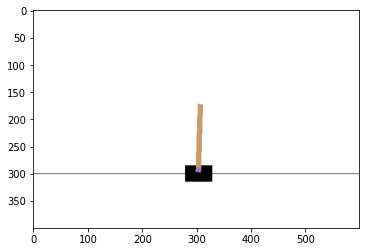

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the policy network

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__. 

We'll use softmax or log-softmax where appropriate.

In [0]:
import tensorflow as tf

# create input variables. We only need <s,a,R> for REINFORCE
# states = tf.placeholder('float32', (None,)+state_dim, name="states")
# actions = tf.placeholder('int32', name="action_ids")
# cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

In [0]:
policy = tf.keras.models.Sequential()
policy.add(tf.keras.layers.Dense(64, activation='relu'))
policy.add(tf.keras.layers.Dense(n_actions, activation='relu'))

# policy = tf.nn.softmax(logits)
# log_policy = tf.nn.log_softmax(logits)

In [27]:
policy(np.array([env.reset()]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.00523839, 0.        ]], dtype=float32)>

In [0]:
# utility function to pick action in one given state
def get_action_proba(s): 
    return tf.nn.softmax(policy(np.array([s]))).numpy()[0]

In [35]:
get_action_proba(env.reset())

array([0.5, 0.5], dtype=float32)

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


### Computing cumulative rewards

In [0]:
def get_cumulative_rewards(rewards,    # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """

    R_t = []
    r_future = 0
    for r_t in rewards[::-1]:
      r_future = r_future * gamma + r_t
      R_t.append(r_future)
    R_t = list(reversed(R_t))
    return R_t

In [15]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
                   [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
                   [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
                   [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


In [0]:
optimizer = tf.keras.optimizers.Adam(1e-3)


def train_step(_states, _actions, _rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    with tf.GradientTape() as tape:
      logits = policy(np.array(_states))
      policy_probs = tf.nn.softmax(logits, axis=-1)
      policy_logprobs = tf.nn.log_softmax(logits, axis=-1)
      indices = tf.stack([tf.range(tf.shape(policy_logprobs)[0]), _actions], axis=-1)
      log_policy_for_actions = tf.gather_nd(policy_logprobs, indices)
      policy_for_actions = tf.gather_nd(policy_probs, indices)

      J = tf.reduce_mean(tf.math.multiply(log_policy_for_actions, _cumulative_rewards))
      entropy = - tf.reduce_mean(tf.math.multiply(log_policy_for_actions, policy_for_actions))
      loss = -J - 0.1 * entropy
    gradients = tape.gradient(loss, policy.trainable_variables)
    optimizer.apply_gradients(zip(gradients, policy.trainable_variables)) 

    #update.run({states: _states, actions: _actions,
    #            cumulative_rewards: _cumulative_rewards})

### Playing the game

In [0]:
def generate_session(env, t_max=1000):
    """play env with REINFORCE agent and train at the session end"""

    # arrays to record session
    states, actions, rewards = [], [], []

    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)

        a = np.random.choice(list(range(action_probas.shape[-1])), size=1, p=action_probas)[0]

        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    train_step(states, actions, rewards)

    # technical: return session rewards to print them later
    return sum(rewards)

In [45]:
for i in range(100):

    rewards = [generate_session(env) for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 300:
        print("You Win!") # but you can train even further
        break

mean reward:26.610
mean reward:30.430
mean reward:34.550
mean reward:40.310
mean reward:47.020
mean reward:65.660
mean reward:85.590
mean reward:107.560
mean reward:150.610
mean reward:179.420
mean reward:208.120
mean reward:275.300
mean reward:270.030
mean reward:263.430
mean reward:323.230
You Win!


### Results & video

In [0]:
# record sessions
import gym.wrappers
monitor_env = gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True)
sessions = [generate_session(monitor_env) for _ in range(100)]
monitor_env.close()

In [47]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

In [48]:
from submit import submit_cartpole
submit_cartpole(generate_session, 'ishalyminov@gmail.com', 'KTgOZ3lFJOWnUzon')

Submitted to Coursera platform. See results on assignment page!


In [0]:
# That's all, thank you for your attention!
# Not having enough? There's an actor-critic waiting for you in the honor section.
# But make sure you've seen the videos first.